In [58]:
from matplotlib import pyplot as plt
import platform, os, sys, time, scipy, h5py
import numpy as np
from tqdm import tqdm
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, approx_fprime
from termcolor import colored, cprint
from scipy.interpolate import RectBivariateSpline

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Problem 1 

In [59]:
N = 10
a = 1.0E-9
q = np.linspace(-6*np.pi/a, 6*np.pi/a, 101)
kl = 2*np.pi/a
hbar = 1.055E-34
m_e = 9.11E-31
U0 = 10 * hbar**2 * kl**2 / (2 * m_e) 

0it [00:00, ?it/s]/Users/gkoolstra/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
101it [00:00, 3179.10it/s]


(-10, 50)

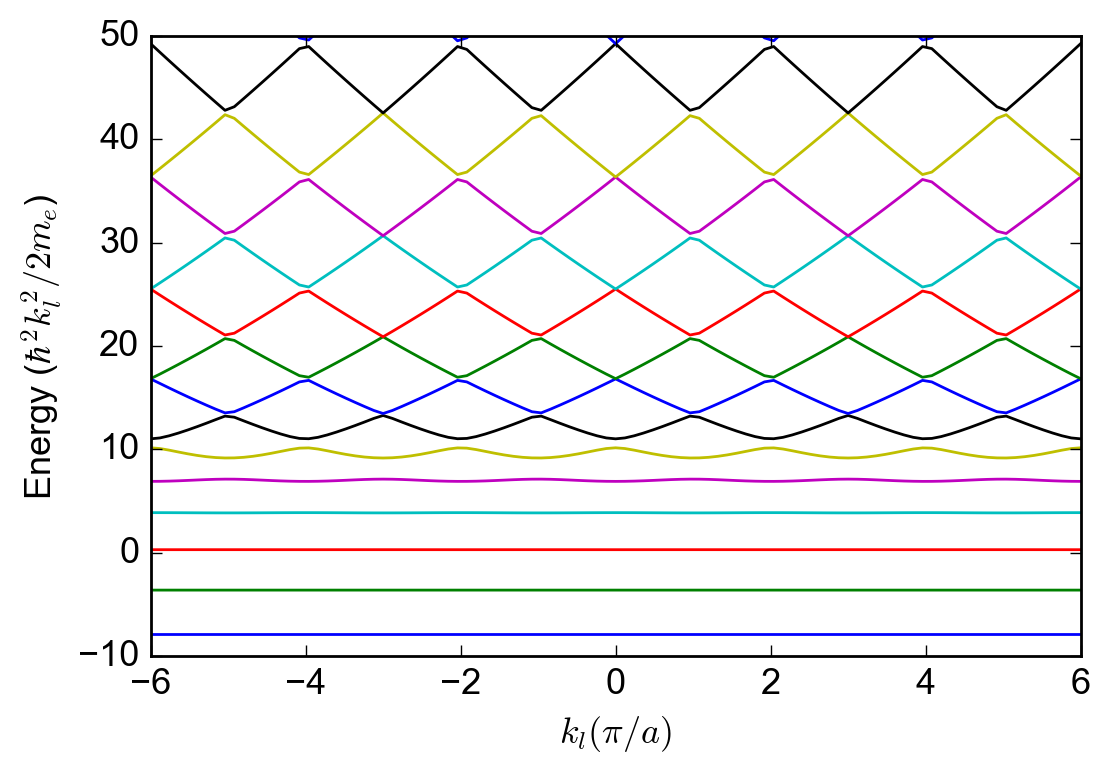

In [71]:
#kl_array = np.linspace(-np.pi/a, +np.pi/a, 2*N+1)
kl_array = np.arange(-N, N+1, 1) * 2*np.pi/a
Eigenvalues = np.zeros((len(q), 2*N+1))

for k, Q in tqdm(enumerate(q)):
    #H = np.zeros((2*N+1, 2*N+1), dtype=np.complex64)
    diag = hbar**2 / (2*m_e) * (Q - kl_array)**2
    off_diag_plusone = -U0 /(2*1j) * np.ones(2*N) 
    off_diag_minone = +U0 /(2*1j) * np.ones(2*N) 
    H = np.diag(diag) + np.diag(off_diag_plusone, 1) + np.diag(off_diag_minone, -1)
    #evals, evecs = scipy.sparse.linalg.eigs
    evals = np.linalg.eigvals(H)
    Eigenvalues[k, :] = 2 * m_e * np.sort(evals) / (hbar**2 * kl**2)
    
plt.figure()
common.configure_axes(13)
plt.plot(q * a/np.pi, Eigenvalues)
plt.xlabel(r"$k_l (\pi/a)$")
plt.ylabel(r"Energy ($\hbar^2 k_l^2 /2 m_e$)")
plt.ylim(-10, 50)    

In [75]:
def Visualize(N):
    
    a = 1.0E-9
    q = np.linspace(-6*np.pi/a, 6*np.pi/a, 101)
    kl = 2*np.pi/a
    hbar = 1.055E-34
    m_e = 9.11E-31
    U0 = 10 * hbar**2 * kl**2 / (2 * m_e) 

    #kl_array = np.linspace(-np.pi/a, +np.pi/a, 2*N+1)
    kl_array = np.arange(-N, N+1, 1) * 2*np.pi/a
    Eigenvalues = np.zeros((len(q), 2*N+1))

    for k, Q in enumerate(q):
        #H = np.zeros((2*N+1, 2*N+1), dtype=np.complex64)
        diag = hbar**2 / (2*m_e) * (Q - kl_array)**2
        off_diag_plusone = -U0 /(2*1j) * np.ones(2*N) 
        off_diag_minone = +U0 /(2*1j) * np.ones(2*N) 
        H = np.diag(diag) + np.diag(off_diag_plusone, 1) + np.diag(off_diag_minone, -1)
        #evals, evecs = scipy.sparse.linalg.eigs
        evals = np.linalg.eigvals(H)
        Eigenvalues[k, :] = 2 * m_e * np.sort(np.real(evals)) / (hbar**2 * kl**2)

    plt.figure()
    common.configure_axes(13)
    plt.plot(q * a/np.pi, Eigenvalues)
    plt.xlabel(r"$k_l (\pi/a)$")
    plt.ylabel(r"Energy ($\hbar^2 k_l^2 /2 m_e$)")
    plt.ylim(-10, 50)
    plt.xlim(-6, 6)
    
    

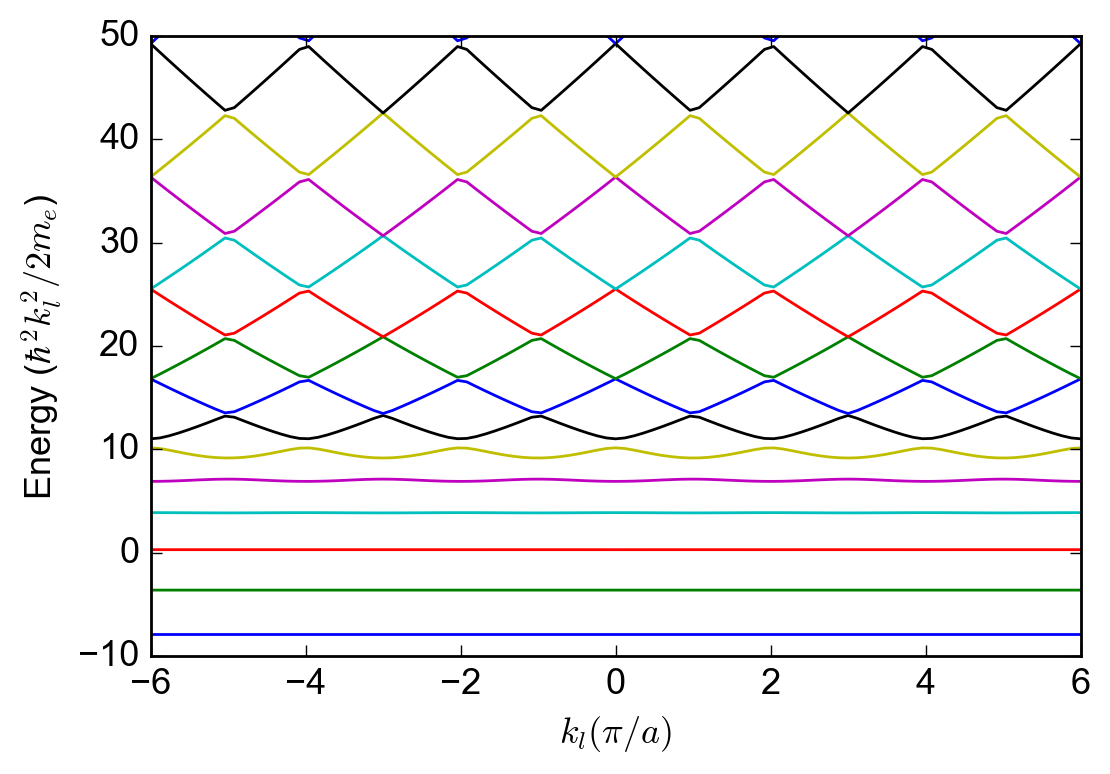

In [76]:
interact(Visualize, N=(1, 25, 1));

# Problem 2 

In [147]:
N = 25
a = 1
kl = 2*np.pi/a
hbar = 1.055E-34
m_e = 9.11E-31
# Note here in this problem, q is momentum (same units as p)
# We can simply multiply the wave vector q with hbar to switch from wave vector
# to real momentum
q = hbar * np.linspace(-6*np.pi/a, 6*np.pi/a, 101)
U0 = 20 * hbar**2 * kl**2 / (2 * m_e)

101it [00:00, 523.46it/s]


(-5, 40)

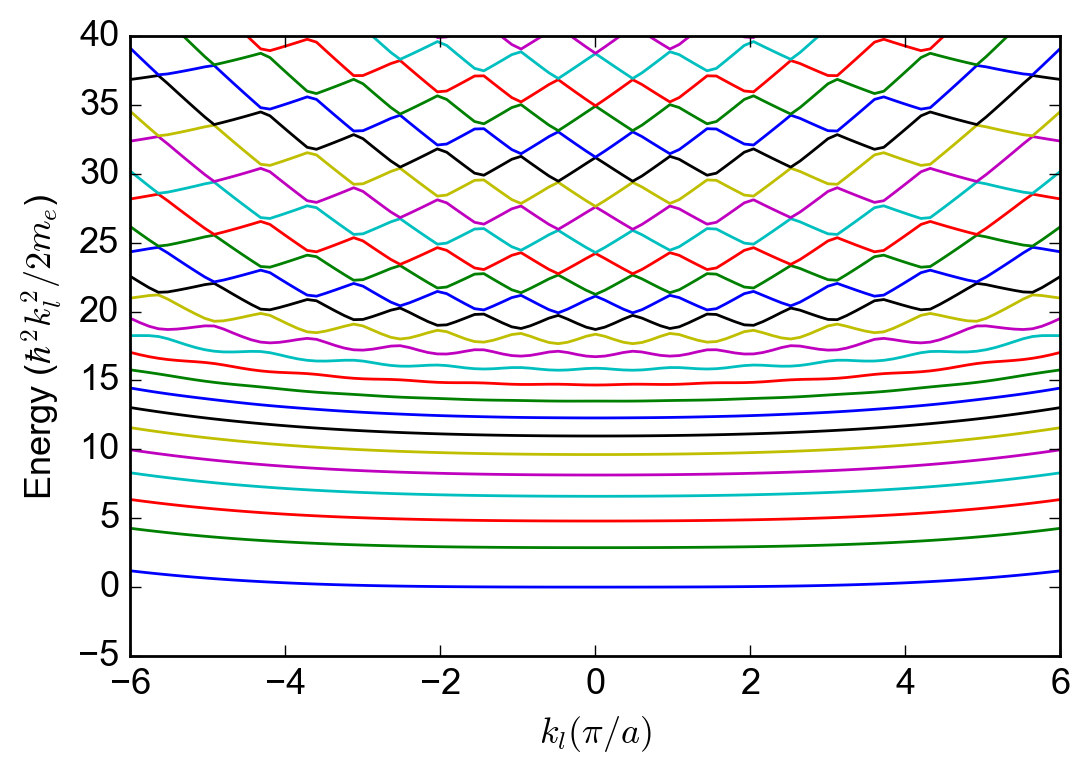

In [148]:
x_array = np.linspace(-a, a, 2*N+1)
Eigenvalues = np.zeros((len(q), 2*N+1))
dx = x_array[1] - x_array[0]
U = U0 * np.abs(x_array/a)

for k, Q in tqdm(enumerate(q)):
    #H = np.zeros((2*N+1, 2*N+1), dtype=np.complex64)
    diag = 1 / (2*m_e) * (Q**2 - 2*hbar**2/dx**2) + U
    off_diag_plusone = 1/(2*m_e) * (hbar**2/dx**2 - 1j*hbar*Q/dx) * np.ones(2*N) 
    off_diag_minone = 1/(2*m_e) * (hbar**2/dx**2 + 1j*hbar*Q/dx) * np.ones(2*N)
    H = np.diag(diag) + np.diag(off_diag_plusone, 1) + np.diag(off_diag_minone, -1)
    H[0, -1] = 1/(2*m_e) * (hbar**2/dx**2 + 1j*hbar*Q/dx)
    H[-1, 0] = 1/(2*m_e) * (hbar**2/dx**2 - 1j*hbar*Q/dx)
    
    evals = np.linalg.eigvals(H)
    Eigenvalues[k, :] = 2 * m_e * np.sort(np.real(evals)) / (hbar**2 * kl**2)
    
lowest_energy = np.min(Eigenvalues)
    
plt.figure()
common.configure_axes(13)
plt.plot(q * a/(np.pi*hbar), Eigenvalues-lowest_energy)
plt.xlabel(r"$k_l (\pi/a)$")
plt.ylabel(r"Energy ($\hbar^2 k_l^2 /2 m_e$)")
plt.ylim(-5, 40)    

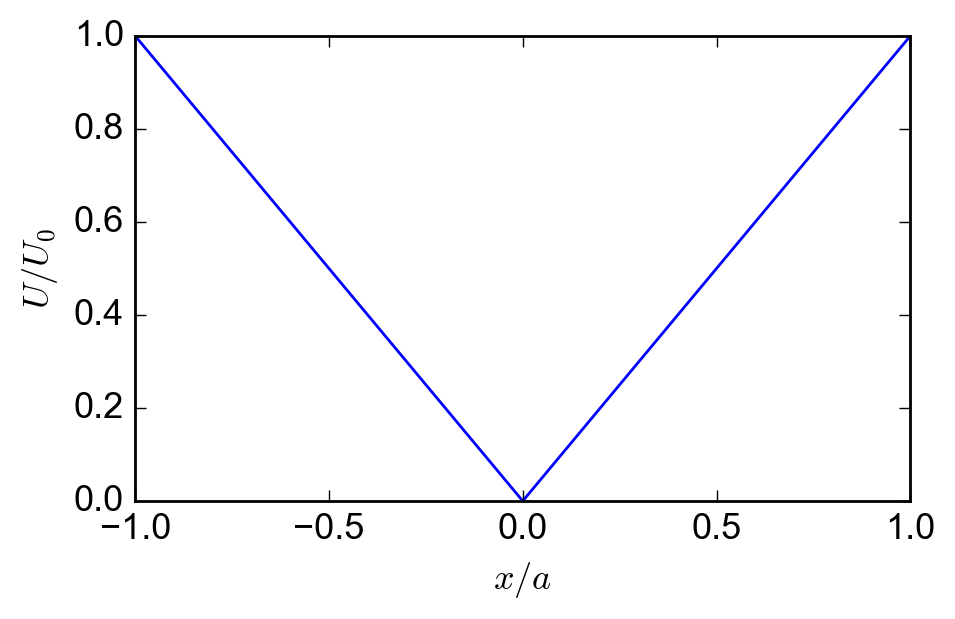

In [159]:
plt.figure(figsize=(5.,3.))
plt.plot(x_array/a, U/U0)
plt.xlabel("$x/a$")
plt.ylabel("$U/U_0$")

In [162]:
def Visualize(N):
    a = 1
    kl = 2*np.pi/a
    hbar = 1.055E-34
    m_e = 9.11E-31
    # Note here in this problem, q is momentum (same units as p)
    # We can simply multiply the wave vector q with hbar to switch from wave vector
    # to real momentum
    q = hbar * np.linspace(-6*np.pi/a, 6*np.pi/a, 101)
    U0 = 20 * hbar**2 * kl**2 / (2 * m_e)

    x_array = np.linspace(-a, a, 2*N+1)
    Eigenvalues = np.zeros((len(q), 2*N+1))
    dx = x_array[1] - x_array[0]
    U = U0 * np.abs(x_array/a)

    for k, Q in enumerate(q):
        #H = np.zeros((2*N+1, 2*N+1), dtype=np.complex64)
        diag = 1 / (2*m_e) * (Q**2 + 2*hbar**2/dx**2) + U
        off_diag_plusone = 1/(2*m_e) * (-hbar**2/dx**2 - 1j*hbar*Q/dx) * np.ones(2*N) 
        off_diag_minone = 1/(2*m_e) * (-hbar**2/dx**2 + 1j*hbar*Q/dx) * np.ones(2*N)
        H = np.diag(diag) + np.diag(off_diag_plusone, 1) + np.diag(off_diag_minone, -1)
        H[0, -1] = 1/(2*m_e) * (-hbar**2/dx**2 + 1j*hbar*Q/dx)
        H[-1, 0] = 1/(2*m_e) * (-hbar**2/dx**2 - 1j*hbar*Q/dx)

        evals = np.linalg.eigvals(H)
        Eigenvalues[k, :] = 2 * m_e * np.sort(np.real(evals)) / (hbar**2 * kl**2)

    lowest_energy = np.min(Eigenvalues)
    
    plt.figure()
    common.configure_axes(13)
    plt.plot(q * a/(np.pi*hbar), Eigenvalues)#-lowest_energy)
    plt.xlabel(r"$k_l (\pi/a)$")
    plt.ylabel(r"Energy ($\hbar^2 k_l^2 /2 m_e$)")
    plt.ylim(-5, 40)    

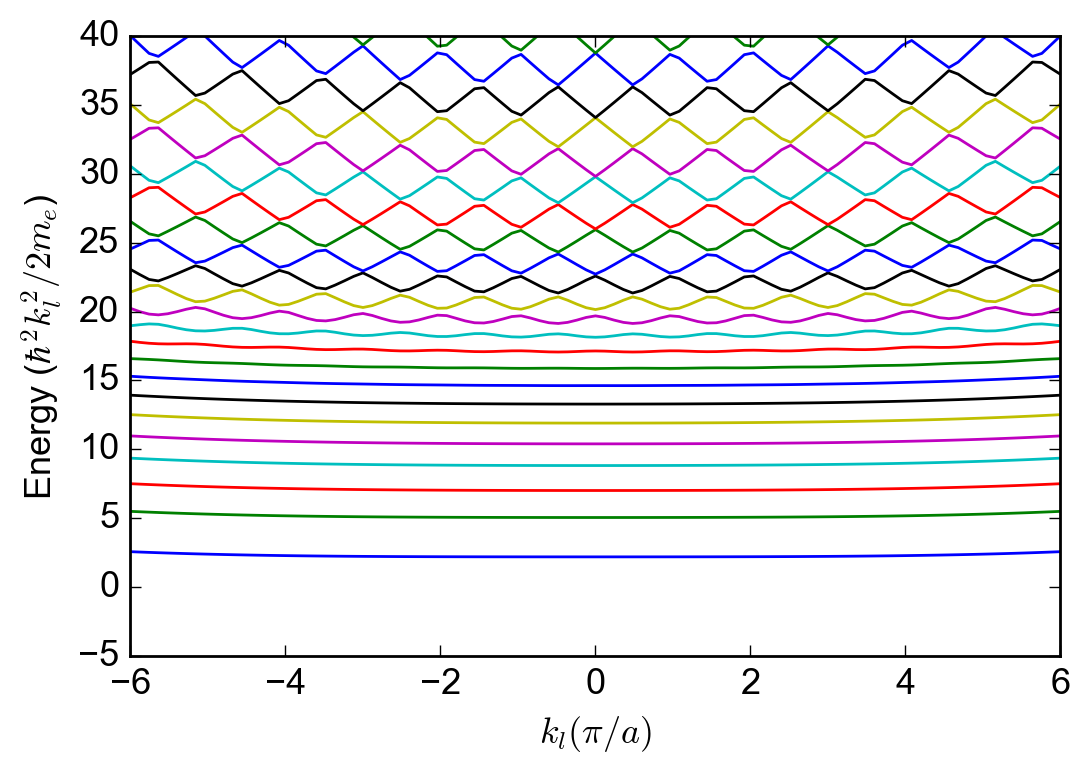

In [163]:
interact(Visualize, N=(1, 50, 1));